In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, MetaData, func
from sqlalchemy.orm import sessionmaker

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# create a metadata object
metadata=MetaData()

# reflect the tables from the database into the metadata object:
metadata.reflect(bind=engine)

In [6]:
# reflect an existing database into a new model
Base = automap_base(metadata=metadata)
# reflect the tables
Base.prepare()

In [7]:
# Get the table names
table_names = metadata.tables.keys()

# Print the table names
for table_name in table_names:
    print(table_name)

measurement
station


In [8]:
# Access the reflected classes
Measurements = Base.classes.measurement
Stations = Base.classes.station

In [9]:
# Save references to each table
measurements_table = Measurements.__table__
stations_table = Stations.__table__

In [10]:
# Perform a query
query = measurements_table.select().where(measurements_table.c.id == 1)
result = engine.execute(query).fetchone()

# Print the query result
print(result)

(1, 'USC00519397', '2010-01-01', 0.08, 65.0)


In [11]:
# Create our session (link) from Python to the DB
Session = sessionmaker(bind=engine)
session = Session()

In [12]:
# Use the session object to perform database operations:
# Perform a query
results = session.query(Measurements.station, Stations.name).filter(Measurements.id == Stations.id).all()

# Print the query results
for result in results:
    print(result)


('USC00519397', 'WAIKIKI 717.2, HI US')
('USC00519397', 'KANEOHE 838.1, HI US')
('USC00519397', 'KUALOA RANCH HEADQUARTERS 886.9, HI US')
('USC00519397', 'PEARL CITY, HI US')
('USC00519397', 'UPPER WAHIAWA 874.3, HI US')
('USC00519397', 'WAIMANALO EXPERIMENTAL FARM, HI US')
('USC00519397', 'WAIHEE 837.5, HI US')
('USC00519397', 'HONOLULU OBSERVATORY 702.2, HI US')
('USC00519397', 'MANOA LYON ARBO 785.2, HI US')


# Exploratory Precipitation Analysis

In [13]:
# Find the most recent date in the data set.
latest_date = session.query(Measurements.date).order_by(Measurements.date.desc()).first()
print("The most recent date in the data set is:", latest_date[0])

The most recent date in the data set is: 2017-08-23


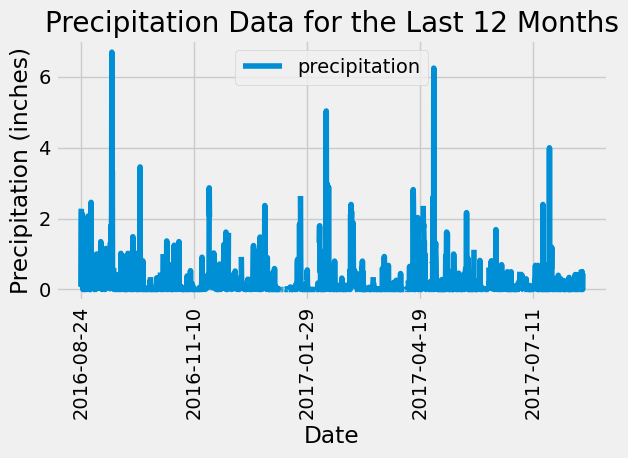

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
latest_date = session.query(Measurements.date).order_by(Measurements.date.desc()).first()

# Calculate the date one year from the last date in data set.
one_year_ago = dt.datetime.strptime(latest_date[0], '%Y-%m-%d') - dt.timedelta(days=365)


# Perform a query to retrieve the data and precipitation scores
query = session.query(Measurements.date, Measurements.prcp).filter(Measurements.date >= one_year_ago).order_by(Measurements.date).all()


# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(query, columns=['date', 'precipitation'])


# Sort the dataframe by date
df = df.sort_values('date')


# Use Pandas Plotting with Matplotlib to plot the data
df.plot(x='date', y='precipitation', rot=90)
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.title('Precipitation Data for the Last 12 Months')
plt.tight_layout()
plt.show()

In [15]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = df['precipitation'].describe()
print("Summary Statistics for Precipitation Data:")
print(summary_stats.round(2))

Summary Statistics for Precipitation Data:
count    2015.00
mean        0.18
std         0.46
min         0.00
25%         0.00
50%         0.02
75%         0.13
max         6.70
Name: precipitation, dtype: float64


# Exploratory Station Analysis

In [16]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Stations.station)).scalar()
print("Total number of stations in the dataset:", total_stations)

Total number of stations in the dataset: 9


In [17]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurements.station, func.count(Measurements.station)).\
    group_by(Measurements.station).\
    order_by(func.count(Measurements.station).desc()).all()

print("Most Active Stations (based on row count):")
for station in active_stations:
    print(f"Station: {station[0]}, Row Count: {station[1]}")

Most Active Stations (based on row count):
Station: USC00519281, Row Count: 2772
Station: USC00519397, Row Count: 2724
Station: USC00513117, Row Count: 2709
Station: USC00519523, Row Count: 2669
Station: USC00516128, Row Count: 2612
Station: USC00514830, Row Count: 2202
Station: USC00511918, Row Count: 1979
Station: USC00517948, Row Count: 1372
Station: USC00518838, Row Count: 511


In [18]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_stations[0][0] 

temperature_stats = session.query(func.min(Measurements.tobs), func.max(Measurements.tobs), func.avg(Measurements.tobs)).\
    filter(Measurements.station == most_active_station).all()

print("Temperature Statistics for the Most Active Station:")
print(f"Lowest Temperature: {temperature_stats[0][0]:.2f}")
print(f"Highest Temperature: {temperature_stats[0][1]:.2f}")
print(f"Average Temperature: {temperature_stats[0][2]:.2f}")

Temperature Statistics for the Most Active Station:
Lowest Temperature: 54.00
Highest Temperature: 85.00
Average Temperature: 71.66


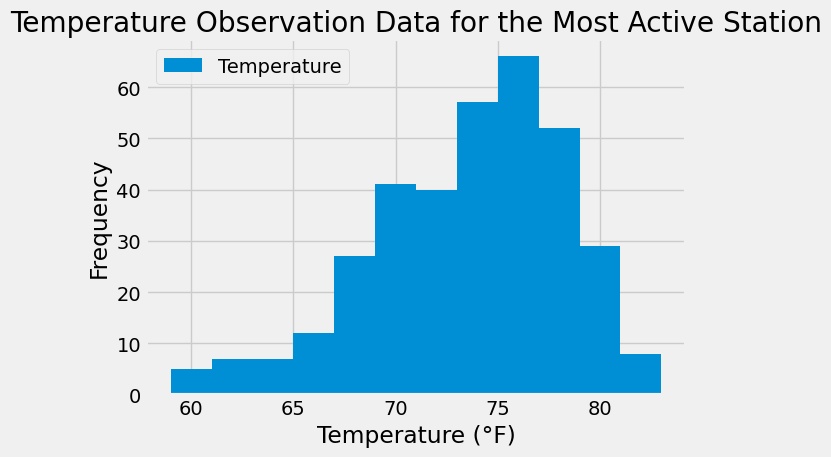

In [19]:
# Using the most active station id 
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
query = session.query(Measurements.tobs).\
    filter(Measurements.station == most_active_station).\
    filter(Measurements.date >= one_year_ago).all()

# Extract the temperature data from the query result
temperatures = [result[0] for result in query]

# Plot the temperature data as a histogram
plt.hist(temperatures, bins=12, label='Temperature')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.title('Temperature Observation Data for the Most Active Station')
plt.legend()
plt.tight_layout()
plt.show()

# Close Session

In [20]:
# Close Session
session.close()